In [41]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score

random.seed(42)
np.random.seed(42)

In [42]:
# функція для генерування цільової змінної
def generate_num_target_dataset(a=5, b=20, dataset_length=10000):
    return pd.DataFrame(np.random.uniform(a, b, size=dataset_length), columns=['target'])


In [43]:
# функція генерує нову змінну, лінійно залежну від вказаної змінної
def linear_dep(row, scale, noise, offset, source='target'):
    return row[source] * scale * (1 + math.copysign(noise, random.random() - 0.5)) + offset

# функція повертає лямбду для генерації нової змінної, лінійно залежну від вказаної змінної
def build_linear_dep(noise, scale=None,  offset=None, source='target'):
    _scale = random.uniform(0.1, 10) if scale == None else scale
    _offset = random.uniform(0, 10 * _scale) if offset == None else offset
    label = f"lin_dep_noise_{noise:.3f}_scale_{_scale:.3f}_offset_{_offset:.3f}"
    print(label)
    return lambda row: linear_dep(row, _scale, noise, _offset, source=source)


In [44]:
# функція генерує датасет з числовою цільовою змінною
def generate_numerical_dataset(dataset_length=10_000):

    df = generate_num_target_dataset()

    lambdas = [
        build_linear_dep(noise=0.30),
        build_linear_dep(noise=0.40),
        build_linear_dep(noise=0.50),
        build_linear_dep(noise=0.20, source='x1'),
        build_linear_dep(noise=0.20, source='x2'),
        build_linear_dep(noise=0.20, source='x3'),
        ]

    for i in range(len(lambdas)):
        df['x{}'.format(i+1)] = df.apply(lambdas[i], axis=1)

    df['x7'] = df['x1'].sample(frac=1).reset_index(drop=True)
    df['x8'] = df['x2'].sample(frac=1).reset_index(drop=True)
    df['x9'] = df['x3'].sample(frac=1).reset_index(drop=True)

    return df


In [66]:
# ще один варіант функції, що генерує датасет з числовою цільовою змінною
def generate_numerical_dataset1(a=5, b=20, dataset_length=10000):
    df = pd.DataFrame({
        'x1': np.random.normal(50, 9, size=dataset_length),
        'x2': np.random.normal(200, 64, size=dataset_length),
        'error': np.random.normal(0, 16, size=dataset_length),
    }
    )

    df['target'] = df.apply(
        lambda row: 150-(4*row['x1']) + (0.5*row['x2'])+row['error'], axis=1)
    df = df.drop('error', axis=1)

    lambdas = [
        build_linear_dep(0.20, source='x1'),
        build_linear_dep(0.20, source='x2'),
    ]

    for i in range(len(lambdas)):
        df['x{}'.format(i+3)] = df.apply(lambdas[i], axis=1)

    df.insert(0, 'target', df.pop('target'))

    return df


In [67]:
num_df = generate_numerical_dataset1(10000)
num_df


lin_dep_noise_0.200_scale_8.524_offset_0.758
lin_dep_noise_0.200_scale_6.060_offset_34.680


,target,x1,x2,x3,x4
0,84.362698,44.539839,263.305955,456.359281,1949.403435
1,74.127026,45.860020,216.862811,469.863495,1086.010404
2,51.328398,44.756476,199.373564,458.575275,1484.496224
3,18.681206,46.340794,119.129542,316.773706,612.208823
4,19.999537,56.540127,243.938718,386.326797,1808.567650
...,...,...,...,...,...
9995,22.843833,53.648176,122.961734,549.529045,928.840315
9996,122.676980,36.566746,214.930349,250.120798,1076.642011
9997,-25.122940,49.923657,68.708654,511.430698,534.319664
9998,37.292600,57.326331,194.862335,587.153125,1451.691207


          target        x1        x2        x3        x4
target  1.000000 -0.709581  0.617740 -0.468239  0.521048
x1     -0.709581  1.000000  0.012514  0.665291  0.008068
x2      0.617740  0.012514  1.000000  0.013536  0.834380
x3     -0.468239  0.665291  0.013536  1.000000  0.008384
x4      0.521048  0.008068  0.834380  0.008384  1.000000


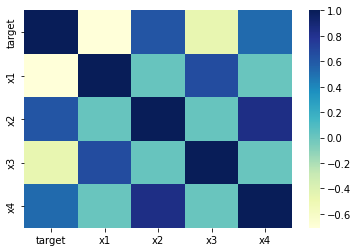

In [68]:
corrmat = num_df.corr(method='pearson')

cmap = "YlGnBu"

print(corrmat)

sns.heatmap(corrmat, cmap=cmap)
plt.show()


In [69]:
def split(df):
    X_tr, X_te, Y_tr, Y_te = train_test_split(
        df.drop('target', axis=1), df['target'], test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te


In [70]:
# функція повертає назви колонок, для яких коефіцієнт кореляції більше ніж порогове значення
def get_correlated_columns(corr_matrix, threshold):
    correlated_columns = set()  # For storing unique value
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
            # absolute values to handle positive and negative correlations
                print(i, j, corr_matrix.iloc[i, j])
                col_name = corr_matrix.columns[i]
                correlated_columns.add(col_name)
    return correlated_columns


In [71]:
model = LinearRegression()

X_train, X_test, Y_train, Y_test = split(num_df)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
acc = r2_score(Y_test, predictions)

columns_to_drop = get_correlated_columns(corrmat, 0.75)
filtered_num_df = num_df.drop(columns_to_drop, axis=1)
print('dropped columns:', columns_to_drop)
X_train, X_test, Y_train, Y_test = split(filtered_num_df)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
acc_filtered = r2_score(Y_test, predictions)

print(f'Model: Linear regression, acc: {acc:.5f}, filtered: {acc_filtered:.5f}')

4 2 0.8343796916109828
dropped columns: {'x4'}
Model: Linear regression, acc: 0.89844, filtered: 0.89837
